# Make a reasonable dictionary for JumpType 

## imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dictionary from https://github.com/hackerb9/gwordlist, here we choose the one verified by wordnet

In [60]:
dict_wn = 'frequency-alpha-wn.txt'
# dict_240k = 'frequency-alpha-alldicts.txt'
# dict_330k = 'count_1w.txt'
# dict_370k = 'words_alpha.txt'

In [61]:
df = pd.read_csv(dict_wn, header=0, delim_whitespace=True, index_col = 0, usecols=[0,1,2], thousands=',', dtype={0:int,1:str,2:np.int64}, na_filter=False)#na_filter avoid 

In [62]:
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='#RANKING'>

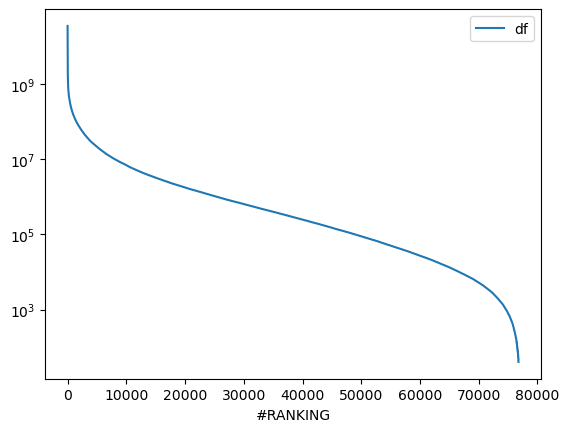

In [63]:
fig, ax = plt.subplots()
# fig.set_size_inches(10,5)
ax.set_yscale('log')
# df_240k.plot(y='COUNT', use_index=True, ax=ax, label='df_240k')
df.plot(y='COUNT', use_index=True, ax=ax, label='df')

## extract proper names

notice that although proper names begin with capital letters, e.g. 'State', the whole dictionary doesn't contain 'state', i.e. they only count once, so we shouldn't extract them naively.

Although we cannot extract proper names, we are sure that non-initial capital letter occurence are not general words

In [128]:
s_non_init_cap = df['WORD'].str.contains('^.+[A-Z]',regex=True)

In [132]:
index_non_init_cap = df.index[s_non_init_cap == True]

In [133]:
df_non_init_cap = df.loc[index_non_init_cap]

In [134]:
df_non_init_cap

,WORD,COUNT
#RANKING,,
278,II,426394344
637,III,222181226
986,IV,150830194
1485,CA,99784715
1799,VI,81619790
...,...,...
75037,dscDNA,771
75151,AMusD,725
75432,LYSINEMIA,575


worth noting there exists some non standard spellings(actually false spelling due to OCR), i.e. they shouldn't be excluded, but we can't save them one by one

In [99]:
df[df['WORD'].str.contains('muton',False).values]

,WORD,COUNT
#RANKING,,
64378,MUton,14756


for initial cap

In [137]:
s_init_cap = df['WORD'].str.contains('^[A-Z]',regex=True)
index_init_cap = df.index[s_init_cap]
df_init_cap = df.loc[index_init_cap]

In [101]:
df_init_cap

,WORD,COUNT
#RANKING,,
10,I,7899588264
44,State,1695745092
79,Act,990641568
101,United,850491753
118,National,757591282
...,...,...
76740,Voltarean,52
76758,Yanquapin,46
76760,Terrietia,46


We use synset to cross-validate: for word with starting capital letter, if it has multiple synset, it is probably not a proper name.

In [91]:
from nltk.corpus import wordnet as wn

In [104]:
wn.synsets('voltarean',lang='eng')

[Synset('voltarian.a.01')]

A short validation function

In [110]:
validation = lambda x: len(wn.synsets(x,lang='eng')) > 1
validation('apple')

True

In [118]:
wn.synsets('Chachka', lang='eng')[0].lemma_names()

['chachka', 'tsatske', 'tshatshke', 'tchotchke', 'tchotchkeleh']

In [140]:
index_init_cap_single_synset = df_init_cap.index[df_init_cap.WORD.apply(validation) == False]

In [142]:
index_init_cap_single_synset

Int64Index([  137,   316,   378,   381,   494,   496,   535,   559,   564,
              594,
            ...
            76728, 76730, 76731, 76734, 76735, 76740, 76758, 76760, 76765,
            76768],
           dtype='int64', name='#RANKING', length=15037)

In [146]:
df.loc[index_init_cap_single_synset]

,WORD,COUNT
#RANKING,,
137,York,670163909
316,June,385700106
378,River,338750630
381,July,335421085
494,April,278684961
...,...,...
76740,Voltarean,52
76758,Yanquapin,46
76760,Terrietia,46


## extract general words
build a general dict first

In [119]:
df_lower = df[~s_non_init_cap.values & ]

In [120]:
df_lower[df_lower['WORD'].str.contains('[A-Z]',regex=True)].iloc[:1000]

,WORD,COUNT
#RANKING,,
10,I,7899588264
44,State,1695745092
79,Act,990641568
101,United,850491753
118,National,757591282
...,...,...
7476,Knox,11287667
7491,Pike,11256536
7498,Monsieur,11246264


### delete non-derived rare words

In [69]:
threshold = 100000
df_lower_rare = df_lower[df_lower['COUNT'] <= threshold]

exclude derived words

the basic idea is to stem all the words and check if the rare word shares the same root with a common word, if so it is a derivation.

In [70]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')

In [71]:
df_lower_common_words = df_lower[df_lower['COUNT'] > threshold]['WORD']

In [72]:
common_roots = set(map(lambda x: stemmer.stem(x), df_lower_common_words.values))

worth noting how many pattern recurs

In [73]:
len(df_lower_common_words.values)

48454

In [74]:
len(common_roots)

35916

In [75]:
rare_word_stemming = map(lambda x: stemmer.stem(x), df_lower_rare['WORD'].values)
rare_is_common_derivation = np.array([True if x in common_roots else False for x in rare_word_stemming])

In [76]:
derived_rare_words = df_lower_rare[rare_is_common_derivation]

Look we have save a considerable amount of words

In [77]:
len(derived_rare_words)/len(df_lower_rare)

0.19880801878273432

Let us see what remains

In [78]:
residue = df_lower_rare[rare_is_common_derivation == False]

Notice that prefixing is also a derivative method, while Snowball stemmer cannot save them since it only detects suffix-derivation.

In [79]:
residue[residue['WORD'].str.contains('^re|^un',regex=True)]

,WORD,COUNT
#RANKING,,
48980,underdone,99780
49000,untraditional,99582
49005,refinish,99528
49011,unsportsmanlike,99462
49021,uncomely,99373
...,...,...
76716,reassail,59
76733,unforethoughtful,54
76745,unpermissiveness,49


But since prefix doesn't change form of the root, it is completely additive that can be treated during typing

## post-processing

In [80]:
df_lower_common_words.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            48951, 48952, 48953, 48954, 48955, 48956, 48957, 48958, 48959,
            48960],
           dtype='int64', name='#RANKING', length=48454)

In [81]:
derived_rare_words.index

Int64Index([48964, 48966, 48968, 48975, 48978, 48981, 48982, 48984, 48985,
            48986,
            ...
            76608, 76610, 76629, 76651, 76672, 76681, 76688, 76689, 76693,
            76746],
           dtype='int64', name='#RANKING', length=5504)

In [82]:
df_final = df_lower.loc[df_lower_common_words.index.append(derived_rare_words.index)]

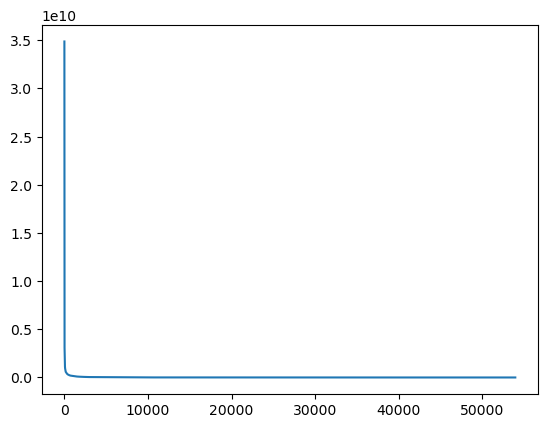

In [83]:
plt.plot(df_final.COUNT.values)

### normalizing word count

rare words frequency set to 0

In [84]:
df_final['COUNT'][df_final['COUNT'] <= threshold] = 0

C:\Users\pc\AppData\Local\Temp\ipykernel_22012\2637873038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['COUNT'][df_final['COUNT'] <= threshold] = 0


normalizing word counts above threshold

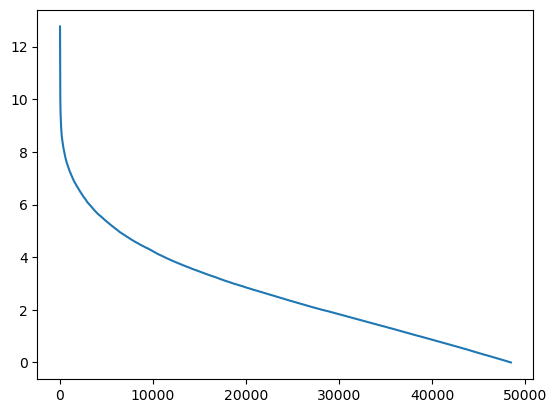

In [85]:
counts = df_final.COUNT[df_final.COUNT > 0]
counts /= counts.min() 
plt.plot(np.log(counts.values))

noticing beyond 10k-th ranking, the plot is almost linear, i.e. ranking = log(freq),
but within 10k-th ranking, it is super-linear

change scale again

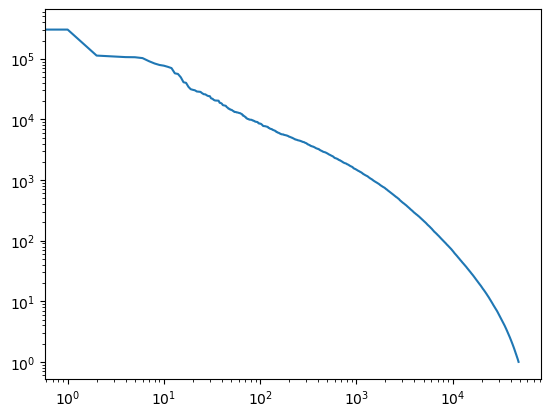

In [86]:
plt.xscale('log')
plt.yscale('log')
plt.plot(counts.values)

C:\Users\pc\AppData\Local\Temp\ipykernel_22012\1522460935.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(np.log(counts[:10000].index), np.log(counts[:10000].values))


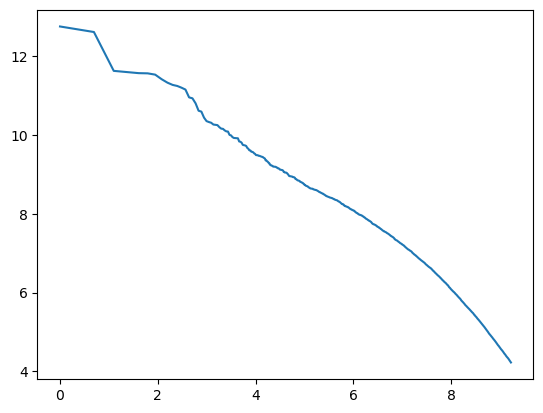

In [87]:
plt.plot(np.log(counts[:10000].index), np.log(counts[:10000].values))

we observe what is called Zipf's law, that is log(freq) is almost linear with log(rank)

In [43]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [44]:
first = 10000
x = np.log(np.array(range(first))+1).reshape(-1,1)
y = np.log(counts.iloc[:first])
model.fit(x,y)
y_pred = model.predict(x)

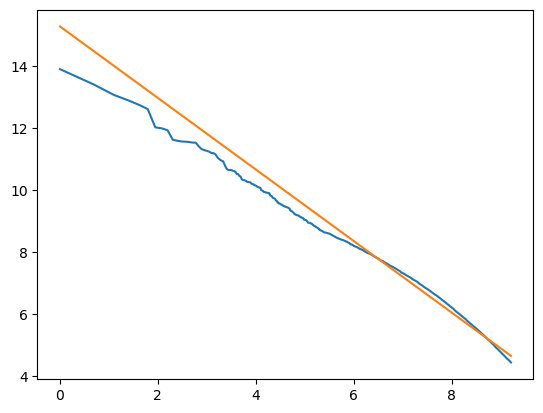

In [45]:
plt.plot(x,y)
plt.plot(x,y_pred)

In [46]:
model.coef_, model.intercept_

(array([-1.1535306]), 15.286210647665207)

$freq = e^{15}ranking^{-1.2}$ for $ranking < 10000$

Remember our goal, normalizing word counts is to save memory. Hence we need to reduce the interval between rankings without changing the order. But the interval should not simply set to 1, since in that way, any single input of a word will be recorded and changes the order . We expect the order is robust enough against users' input, reflecting some general prior word frequency. 

In [47]:
counts = np.round(counts).astype(int)

In [48]:
counts

#RANKING
1        1098774
2         668049
3         479303
4         403343
5         348619
          ...   
72198          1
72199          1
72200          1
72201          1
72202          1
Name: COUNT, Length: 71220, dtype: int32

In [49]:
diff = counts.diff()
diff_distribution = diff.value_counts()

In [50]:
diff_distribution.iloc[:6].sum()/diff_distribution.sum()

0.9939903677389461

note that in the diff distribution, over 99% diffs is within 5, hence we can truncate diff by 5

In [51]:
diff[diff<-5] = -5

In [52]:
diff.value_counts()

 0.0    68954
-1.0     1354
-5.0      474
-2.0      227
-3.0      124
-4.0       86
Name: COUNT, dtype: int64

inverse diff

In [53]:
normalized_count = np.r_[counts.iloc[0],diff.iloc[1:]].cumsum().astype(int)

In [54]:
normalized_count -= normalized_count.min()-1

In [55]:
df_final.COUNT[df_final.COUNT>threshold] = normalized_count

C:\Users\pc\AppData\Local\Temp\ipykernel_22012\592500369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.COUNT[df_final.COUNT>threshold] = normalized_count


compare with the previous count plot, we reduce greatly the order while capturing the ranking shape

<AxesSubplot: xlabel='#RANKING'>

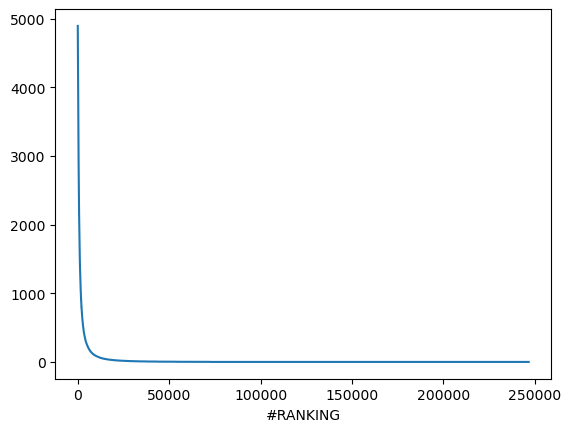

In [56]:
df_final.COUNT.plot()

## Stash

In [57]:
df_final.to_csv('dict_en.yaml',sep='\t')

## Encoding

Now let us encoding the vocabularies, the idea is simple: remove all the non-starting vowels

In [379]:
word = df_final.WORD.to_numpy()

compute word-length frequency

In [394]:
len(word)

43684

In [401]:
wd_length_freq = list(map(len, word))

(array([3.000e+00, 6.700e+01, 5.270e+02, 1.784e+03, 2.928e+03, 4.512e+03,
        5.570e+03, 6.239e+03, 6.301e+03, 5.301e+03, 3.932e+03, 2.642e+03,
        1.806e+03, 9.970e+02, 5.630e+02, 2.800e+02, 1.390e+02, 4.000e+01,
        3.100e+01, 1.600e+01, 4.000e+00, 2.000e+00]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]),
 <BarContainer object of 22 artists>)

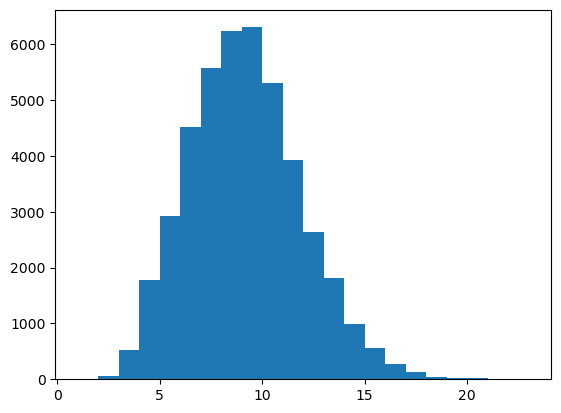

In [404]:
plt.hist(np.array(wd_length_freq),bins=range(min(wd_length_freq), max(wd_length_freq)+1,1))

In [375]:
import re

In [ ]:
re.sub('')